Building a Generative Neural Network from Scratch in Python

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from scipy.linalg import sqrtm

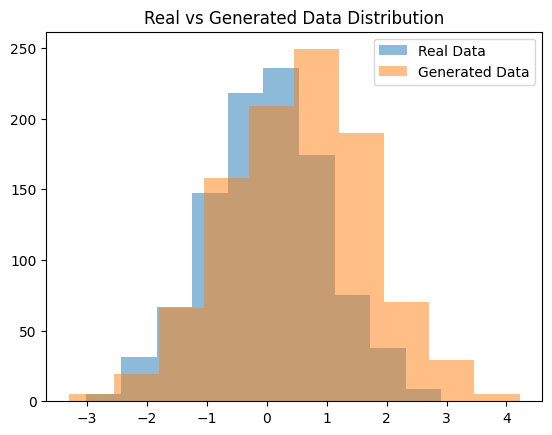

In [2]:

np.random.seed(43)
real_data = np.random.normal(0, 1, 1000)
generated_data = np.random.normal(0.5, 1.2, 1000)

plt.hist(real_data, alpha=0.5, label='Real Data')
plt.hist(generated_data, alpha=0.5, label='Generated Data')
plt.legend()
plt.title('Real vs Generated Data Distribution')
plt.show()


In [20]:
def build_generator(input_dim, output_dim=784):
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(128, input_dim=input_dim, activation='relu'),
        tf.keras.layers.Dense(256,activation='relu'),
        tf.keras.layers.Dense(output_dim, activation='tanh')
    ])
    return model

def build_discriminator(input_dim=784):
    model = tf.keras.Sequential([ 
        tf.keras.layers.Dense(256, input_dim=input_dim,activation='relu'),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    return model

generator = build_generator(100, 784)  # For generating 28x28 images
discriminator = build_discriminator(784)
generator_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)


In [4]:
def generate_noise(batch_size, noise_dim):
    return np.random.normal(0,1,size=(batch_size, noise_dim))

batch_size = 64
noise_dim=100
noise = generate_noise(batch_size=batch_size,noise_dim=noise_dim)

print(noise.shape,noise[0][:10])


(64, 100) [-0.60272245 -0.5565732  -0.12567435  1.42231805 -0.10845608  0.97378041
 -0.95868342  0.36972364  0.21890863  0.30123978]


In [5]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

fake_output = tf.random.uniform((64,1))
gen_loss = generator_loss(fake_output)
# print(gen_loss)
print(gen_loss.numpy())

real_output = tf.random.uniform((64,1))
disc_loss = discriminator_loss(real_output, fake_output)
print(disc_loss.numpy())


0.49059248
1.4639486


In [6]:
@tf.function
def train_step(real_images):
    noise = generate_noise(batch_size, noise_dim)
    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)
        
        real_output = discriminator(real_images, training=True)
        fake_output = discriminator(generated_images, training=True)
        
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)
    
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    
    return gen_loss, disc_loss



In [7]:
# def generate_and_plot_images(generator, noise_dim, num_examples=16):
#     noise = generate_noise(num_examples, noise_dim)
#     generated_images = generator(noise, training=False)
    
#     fig = plt.figure(figsize=(4, 4))
#     for i in range(num_examples):
#         plt.subplot(4, 4, i+1)
#         plt.imshow(generated_images[i,:,:,0] * 0.5 + 0.5, cmap='gray')
#         plt.axis('off')
#     plt.tight_layout()
#     plt.show()

# generate_and_plot_images(generator, noise_dim)
def generate_and_plot_images(generator, noise_dim, num_examples=16):
    noise = generate_noise(num_examples, noise_dim)  # Generate noise for num_examples
    generated_images = generator(noise, training=False)  # Generate images from noise
    
    # Reshape generated images from (num_examples, 784) to (num_examples, 28, 28)
    generated_images = generated_images.numpy().reshape(num_examples, 28, 28)

    plt.figure(figsize=(10, 10))
    for i in range(num_examples):
        plt.subplot(4, 4, i + 1)
        plt.imshow(generated_images[i] * 0.5 + 0.5, cmap='gray')  # Normalize for visualization
        plt.axis('off')
    plt.tight_layout()
    plt.show()



In [8]:
from tensorflow.keras.datasets import mnist # type: ignore

In [9]:
(train_images, _),(_,_) = mnist.load_data()
print(train_images.shape)
train_images = train_images.reshape(train_images.shape[0],28,28,1).astype('float32')
print(train_images.shape)
train_images = (train_images - 127.5) / 127.5
train_images = train_images.reshape(train_images.shape[0],-1)
print(train_images.shape)

(60000, 28, 28)
(60000, 28, 28, 1)
(60000, 784)


In [10]:
generator = build_generator(100,784)
discriminator = build_discriminator(784)
print(generator.summary(),discriminator.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 128)               12928     
                                                                 
 dense_7 (Dense)             (None, 256)               33024     
                                                                 
 dense_8 (Dense)             (None, 784)               201488    
                                                                 
Total params: 247440 (966.56 KB)
Trainable params: 247440 (966.56 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 256)               200960    
                                                          

In [11]:
# for epoch in range(2):
#     print(epoch)
#     for i in range(0,  len(train_images), batch_size):
#         batch = train_images[i:i + batch_size]
#         noise = generate_noise(batch_size,100)
#         with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
#             generated_images = generator(noise, training = True)
#             real_output = discriminator(batch, training = True)

#             gen_loss = generator_loss(fake_output)
#             disc_loss = discriminator_loss(real_output, fake_output)

#         gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
#         gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

#         # Apply gradients
#         generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))

# discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
# print(f'Generator Loss: {gen_loss.numpy()}, Discriminator Loss: {disc_loss.numpy()}')
# generate_and_plot_images(generator, noise_dim=100)
for epoch in range(2):
    print(f'Epoch {epoch + 1}/{50}')
    for i in range(0, len(train_images), batch_size):
        batch = train_images[i:i + batch_size]
        noise = generate_noise(batch_size, 100)

        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            generated_images = generator(noise, training=True)
            real_output = discriminator(batch, training=True)
            fake_output = discriminator(generated_images, training=True)

            gen_loss = generator_loss(fake_output)
            disc_loss = discriminator_loss(real_output, fake_output)

        # Compute gradients
        gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
        gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

        # Check for empty gradients
        if all(g is None for g in gradients_of_generator):
            print("No gradients for generator")
        
        if all(g is None for g in gradients_of_discriminator):
            print("No gradients for discriminator")

        # Apply gradients only if they are not None
        if any(g is not None for g in gradients_of_generator):
            generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
        
        if any(g is not None for g in gradients_of_discriminator):
            discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    # Print losses at the end of each epoch
    print(f'Generator Loss: {gen_loss.numpy()}, Discriminator Loss: {disc_loss.numpy()}')

Epoch 1/50


C:\Users\aagam\AppData\Roaming\Python\Python311\site-packages\keras\src\backend.py:5818: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


Generator Loss: 2.80495548248291, Discriminator Loss: 0.13603167235851288
Epoch 2/50
Generator Loss: 2.191577911376953, Discriminator Loss: 0.4251265525817871


1/1 [==============================] - 0s 235ms/step


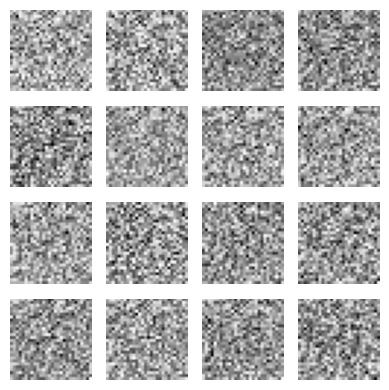

In [12]:
def build_conditional_generator(noise_dim, num_classes):
    noise_input = tf.keras.Input(shape = (noise_dim,))
    label_input = tf.keras.Input(shape = (1,))

    label_embedding = tf.keras.layers.Embedding(num_classes, 50)(label_input)
    label_embedding = tf.keras.layers.Flatten()(label_embedding)
    combined_input = tf.keras.layers.Concatenate()([noise_input,label_embedding])

    x=tf.keras.layers.Dense(256, activation='relu')(combined_input)
    x=tf.keras.layers.Dense(512, activation='relu')(x)
    output = tf.keras.layers.Dense(784, activation='tanh')(x)
    

    return tf.keras.Model([noise_input, label_input], output)

conditional_generator = build_conditional_generator(100, 10)

noise = generate_noise(16, 100)
labels = np.full((16, 1), 5)
generated_images = conditional_generator.predict([noise, labels])

plt.figure(figsize=(4,4))
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.imshow(generated_images[i].reshape(28,28), cmap='Greys')
    plt.axis('off')
plt.tight_layout()
plt.show()

In [16]:
def calculate_fid(real_images, generated_images):
    # Assume we have a pre-trained model for feature extraction
    feature_extractor = tf.keras.applications.InceptionV3(include_top=False, pooling='avg', input_shape=(299,299,3))
    
    def preprocess_images(images):
        images = tf.image.resize(images, (299, 299))
        images = tf.keras.applications.inception_v3.preprocess_input(images)
        return images
    
    real_features = feature_extractor.predict(preprocess_images(real_images))
    generated_features = feature_extractor.predict(preprocess_images(generated_images))
    
    mu1, sigma1 = real_features.mean(axis=0), np.cov(real_features, rowvar=False)
    mu2, sigma2 = generated_features.mean(axis=0), np.cov(generated_features, rowvar=False)
    
    ssdiff = np.sum((mu1 - mu2)**2.0)
    covmean = sqrtm(sigma1.dot(sigma2))
    
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    
    fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
    return fid

# (real_samples, _), (_, _) = mnist.load_data()

# # Convert grayscale images to 3 channels (RGB)
# real_samples = np.stack([real_samples] * 3, axis=-1)  # Convert to RGB

# # Normalize the images to [0, 1]
# real_samples = real_samples.astype('float32') / 255.0

# # Function to resize images in batches
# def resize_in_batches(images, batch_size=10):
#     resized_images = []
#     for i in range(0, len(images), batch_size):
#         batch = images[i:i+batch_size]
#         resized_batch = tf.image.resize(batch, (299, 299))
#         resized_images.append(resized_batch)
#     return np.concatenate(resized_images, axis=0)

# # Resize the images in smaller batches to avoid OOM
# real_samples_resized = resize_in_batches(real_samples, batch_size=1000)

# # Proceed with your FID calculation
# generated_samples = generator.predict(generate_noise(1000, noise_dim))
# fid_score = calculate_fid(real_samples_resized, generated_samples)
# print(f"FID Score: {fid_score}")


In [22]:
from tensorflow.keras.datasets import fashion_mnist

(train_images,_),(_,_) = fashion_mnist.load_data()
train_images = train_images.reshape(train_images.shape[0],28,28,1).astype('float32')
train_images = (train_images - 127.5) / 127.5

generator = build_generator(100,784)
discriminator = build_discriminator(784)

# for epoch in range(10):
#     for batch in train_images:
#         noise = generate_noise(batch_size, 100)
#         with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
#             generated_images = generator(noise, training = True)
#             real_output = discriminator(batch,training = True)
#             fake_output = discriminator(generated_images, training = True)

#             gen_loss = generator_loss(fake_output)
#             disc_loss = discriminator_loss(real_output,fake_output)

# generate_and_plot_images(generator,100)